#### Loads

In [12]:
import pandas as pd
from DeepRetail.forecasting.statistical import StatisticalForecaster
from DeepRetail.exploratory.eda import get_features
from matplotlib import pyplot as plt
from DeepRetail.evaluation.base import Evaluator
# Import metrics for evaluation
from DeepRetail.evaluation.metrics import rmsse, scaled_error, mape
from DeepRetail.exploratory.eda import get_features
from DeepRetail.transformations.formats import MinMaxScaler_custom
from DeepRetail.forecasting.ml import GlobalForecaster
import lightgbm as lgb
import numpy as np

from DeepRetail.reconciliation.temporal import THieF, TemporalReconciler
from DeepRetail.reconciliation.utils import get_factors
from DeepRetail.reconciliation.cross_sectional import CHieF, CrossSectionalReconciler
from DeepRetail.transformations.formats import hierarchical_to_transaction, extract_hierarchical_structure
from DeepRetail.reconciliation.cross_temporal import CrossTemporalReconciler, C_THieF

In [13]:
# Define metrics
metrics = [rmsse, scaled_error, mape]

In [14]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/VCF_data.csv', index_col=0)
df.head()

,PRODUCT_CODE,ORDER_DATE,FAM,Sales
0,01001009108,2014-06-06,J.CORTES,54.0
1,01001009108,2014-09-09,J.CORTES,27.0
2,01001009108,2014-09-10,J.CORTES,27.0
3,01001009108,2014-09-11,J.CORTES,72.0
4,01001009108,2014-09-12,J.CORTES,135.0


In [15]:
# Make the unique_id column
df['unique_id'] = df['PRODUCT_CODE'].astype(str) + '_' + df['FAM'].astype(str)

# Pivot
df = df.pivot(index='unique_id', columns='ORDER_DATE', values='Sales')

In [16]:
# convert columns to datetime
df.columns = pd.to_datetime(df.columns)

# Drop columns with only nans
df = df.dropna(axis = 0, how = 'all')
df = df.fillna(0)

# Drop rows with only zeros
df = df.loc[~(df==0).all(axis=1)]

# resample to monthly
df = df.resample('M', axis = 1).sum()

# Drop the last month cuz its incomplete
df = df.drop(df.columns[-1], axis = 1)

# Drop information prior to 2015
df = df.loc[:, df.columns >= '2015-01-31']

# We stop at the second month of 2022
df = df.iloc[:,:-10]

In [17]:
# Count non zero observations per row on df
non_zero_obs = df.astype(bool).sum(axis=1)

# Total series with over 5 non zero observations
print(len(non_zero_obs))
len(non_zero_obs[non_zero_obs > 5])

7569


3028

##### Split Data for the two Experiments

In [18]:
# Filter df to only include series with over 5 non zero observations
sample_df = df.loc[non_zero_obs[non_zero_obs > 5].index]
sample_df.shape

(3028, 85)

In [19]:
# Loading the original df
sample_df_2 = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/example_notebooks/experiment/base_forecasts/temp_rec_vcf.csv', index_col=0)
sample_df_2.shape

(409, 116)

In [20]:
# Drop columns that only have zeros
print(sample_df.shape)
sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
sample_df.shape

(3028, 85)


(3028, 85)

3028


1109

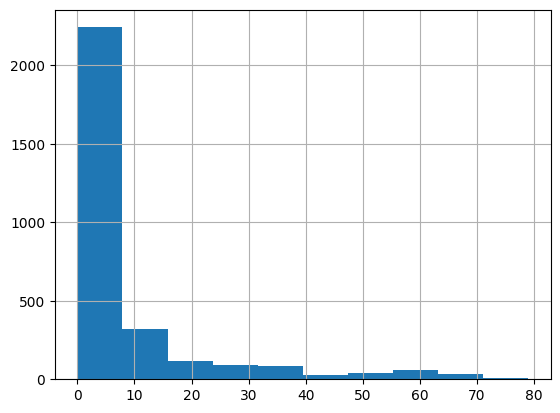

In [21]:
# Check the number of trailing zeros, zeros at the end of the sequence per row

def count_zeros_row(ts):
    # count zeros at the end of the sequence until the first non zero element
    count = 0
    for i in range(len(ts)-1, -1, -1):
        if ts[i] == 0:
            count += 1
        else:
            break
    return count

# Count zeros at the end of the sequence per row
trailing_zeros = sample_df.apply(count_zeros_row, axis = 1)
trailing_zeros_2 = sample_df_2.apply(count_zeros_row, axis = 1)
trailing_zeros.hist()

# Total series with over 5 non zero observations and less than 5 trailing zeros 
print(len(trailing_zeros))
len(trailing_zeros[(trailing_zeros < 5) & (trailing_zeros > 0)])


In [22]:
# Keep only series with over 5 non zero observations and less than 5 trailing zeros
# sample_df is already filtered for non zero observations
# only filter for trailing zeros
sample_df = sample_df.loc[trailing_zeros[(trailing_zeros < 5) & (trailing_zeros > 0)].index]
# same for the second
#sample_df_2 = sample_df_2.loc[trailing_zeros_2[(trailing_zeros_2 < 5) & (trailing_zeros_2 > 0)].index]

sample_df


ORDER_DATE,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,...,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31
unique_id,,,,,,,,,,,,,,,,,,,,,
01006025108_J.CORTES,2325.0,1900.0,1000.0,1700.0,2200.0,1700.0,1425.0,2050.0,2525.0,1450.0,...,1500.0,1625.0,2375.0,3875.0,2450.0,1675.0,1425.0,375.0,450.0,0.0
01007005124_J.CORTES,0.0,0.0,2000.0,0.0,2000.0,2000.0,6000.0,0.0,4000.0,2000.0,...,0.0,0.0,0.0,1800.0,0.0,7200.0,0.0,0.0,3600.0,0.0
01007025149_J.CORTES,875.0,300.0,800.0,1100.0,700.0,1350.0,1300.0,1425.0,875.0,2575.0,...,500.0,0.0,1500.0,0.0,125.0,1250.0,0.0,0.0,750.0,0.0
01008005108DFSE_J.CORTES,0.0,1000.0,0.0,0.0,1000.0,0.0,0.0,0.0,2000.0,0.0,...,0.0,400.0,1600.0,0.0,0.0,1000.0,0.0,0.0,1000.0,0.0
01008005117_J.CORTES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1540.0,0.0,0.0,990.0,0.0,1155.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89008005182_OTHER PROJECTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,147200.0,0.0,0.0,0.0,0.0
89009050182_OTHER PROJECTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18000.0,0.0,0.0,0.0,0.0
89010020182_OTHER PROJECTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48000.0,0.0,0.0,0.0,0.0


#### Basic EDA

In [23]:
features = get_features(sample_df, seasonal_period = 12, periods = 12)
# Use thecustom minmax scaler to normalize lumpiness into 0-1
features['lumpiness'] = MinMaxScaler_custom(features['lumpiness'], feature_range=(0, 1))
features['linearity'] = MinMaxScaler_custom(features['linearity'], feature_range=(0, 1))
features

,unique_id,lumpiness,entropy,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough,Residual_CoV
0,01006025108_J.CORTES,0.075308,0.879325,1,12,0.199897,0.000146,0.518646,0.092293,-0.087163,0.103406,0.380872,7,4,0.978547
1,01007005124_J.CORTES,0.018510,0.859342,1,12,0.040440,0.000141,0.495704,-0.066259,-0.201681,0.223582,0.322394,9,11,0.810839
2,01007025149_J.CORTES,0.026293,0.850845,1,12,0.158952,0.000106,0.461260,-1.933102,-0.284641,0.305131,0.371607,9,3,0.898071
3,01008005108DFSE_J.CORTES,0.014496,0.881729,1,12,0.062810,0.000103,0.617410,0.546966,-0.278584,0.208732,0.316749,6,1,0.765054
4,01008005117_J.CORTES,0.345382,0.899665,1,12,0.227629,0.001301,0.794087,1.168945,-0.173690,0.193593,0.235004,4,1,0.396069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,89008005182_OTHER PROJECTS,0.235312,0.911183,1,12,0.120611,0.001094,0.713380,-1.137711,-0.230100,0.111873,0.181705,7,11,0.432337
1105,89009050182_OTHER PROJECTS,0.230249,0.901556,1,12,0.124856,0.000606,0.729495,-0.855018,-0.174264,0.223457,0.186649,7,3,0.419443
1106,89010020182_OTHER PROJECTS,0.294807,0.862018,1,12,0.088402,0.001490,0.669130,-1.336695,-0.260248,0.098898,0.164658,8,3,0.264138
1107,89011010182_OTHER PROJECTS,0.216079,0.905473,1,12,0.136308,0.000854,0.702552,-1.252276,-0.085102,0.144571,0.189325,7,3,0.447483


In [24]:
# Lumpiness -> the variability of the variability of the series

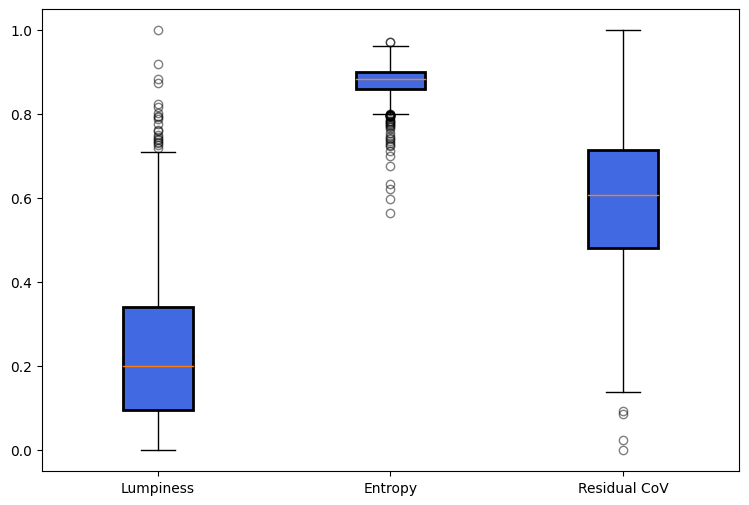

In [25]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['lumpiness'], features['entropy'], features['Residual_CoV']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['Lumpiness', 'Entropy', 'Residual CoV'])

plt.show()

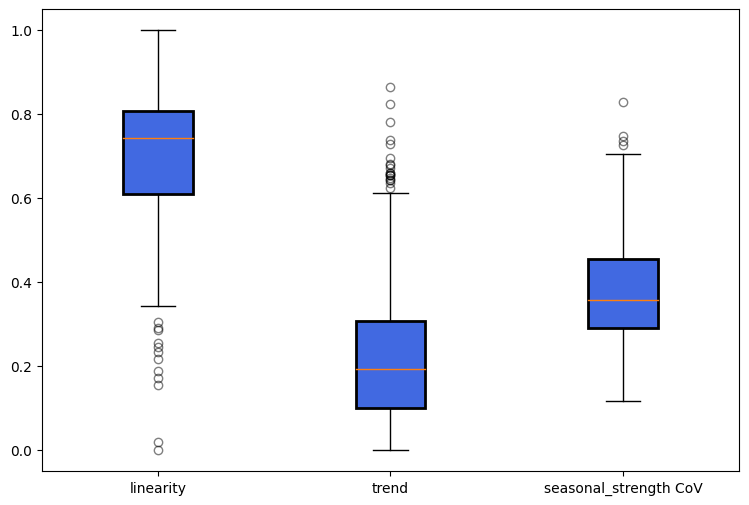

In [26]:
# Three boxplots for lumpiness, entropy and residual_cov on the same figure

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot([features['linearity'], features['trend'], features['seasonal_strength']], patch_artist=True)

# Make the boxplot darkblue and the lines black
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=2)
    # change fill color to dark blue
    box.set( facecolor = 'royalblue' )

# change the outlier colors
for flier in bp['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)


# Give names
ax.set_xticklabels(['linearity', 'trend', 'seasonal_strength CoV'])

plt.show()

#### Statistical Forecaster

In [27]:
# Define some parameters
freq = 'M'
holdout = True
h = 6
cv = 4
models = ['ETS', 'Naive', 'SNaive', 'CrostonOptimized']

In [28]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq, distributed=True, n_partitions=10)

# Fit the forecaster
forecaster.fit(sample_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

2023-04-06 16:05:49,814 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8rv11r_v', purging
2023-04-06 16:05:49,815 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-lqbx8y70', purging
2023-04-06 16:05:49,816 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-pfdclf6n', purging
2023-04-06 16:05:49,817 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zp93shgg', purging


make fugue


In [29]:
# Evaluate

# Define the evaluator
evaluator = Evaluator(sample_df, forecast_df, freq = freq, format = 'pivoted')
eval_df = evaluator.evaluate(metrics = metrics)

# keep only relevant columns
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
26616,01008005133A_J.CORTES,Naive,1,1,0.962755,-0.000927,0.000000
26617,01008005133A_J.CORTES,Naive,2,1,1.444132,0.001390,0.600000
26618,01008005133A_J.CORTES,Naive,3,1,0.962755,-0.000927,0.000000
26619,01008005133A_J.CORTES,Naive,4,1,0.962755,-0.000927,0.000000
26620,01008005133A_J.CORTES,Naive,5,1,0.962755,-0.000927,0.000000
...,...,...,...,...,...,...,...
133075,81808100162_PRIVATE LABEL,CrostonOptimized,5,4,0.474889,-0.000457,0.000000
133076,81808100162_PRIVATE LABEL,CrostonOptimized,6,4,28.407751,0.027350,0.983558
133077,81808100162_PRIVATE LABEL,CrostonOptimized,7,4,0.474889,-0.000457,0.000000
133078,81808100162_PRIVATE LABEL,CrostonOptimized,8,4,14.929186,0.014373,0.969171


##### EDA on the Results

In [30]:
# merge eval_df with features on the unique
# groupby on time-series and model
eval_df_ = eval_df.groupby(['unique_id', 'Model']).mean().reset_index()

# add the features
eval_df_ = pd.merge(eval_df_, features, left_on = 'unique_id', right_on = 'unique_id', how = 'left')

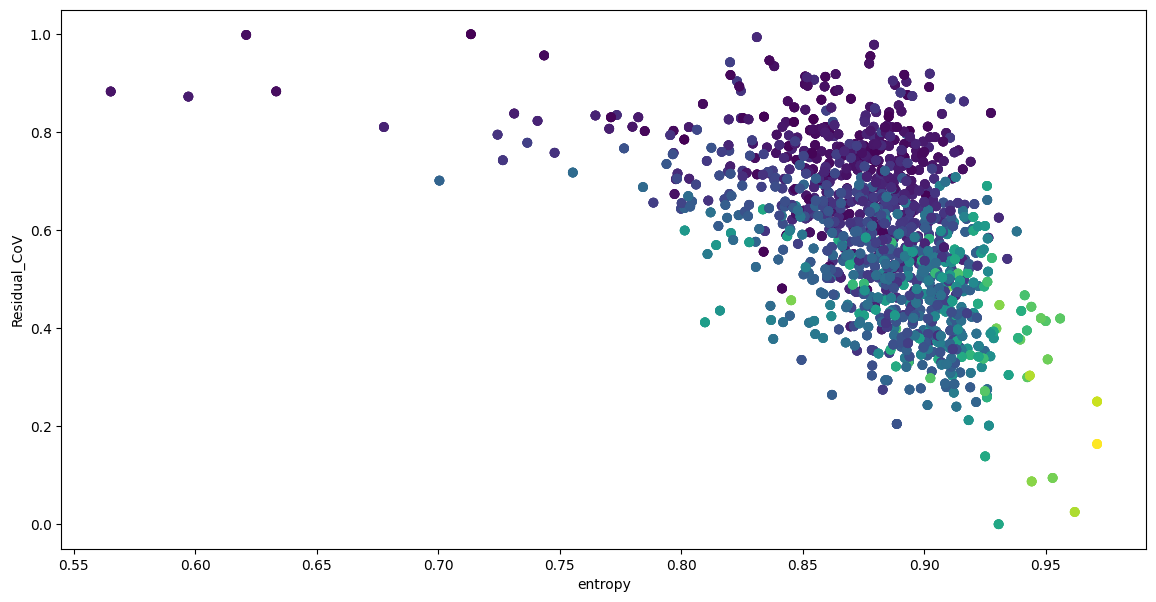

In [31]:
# A scatter plot with entropy on x and Residual_CoV on y 

plt.figure(figsize = (14,7))
plt.scatter(eval_df_['entropy'], eval_df_['Residual_CoV'], c = eval_df_['lumpiness'])

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')
plt.show()



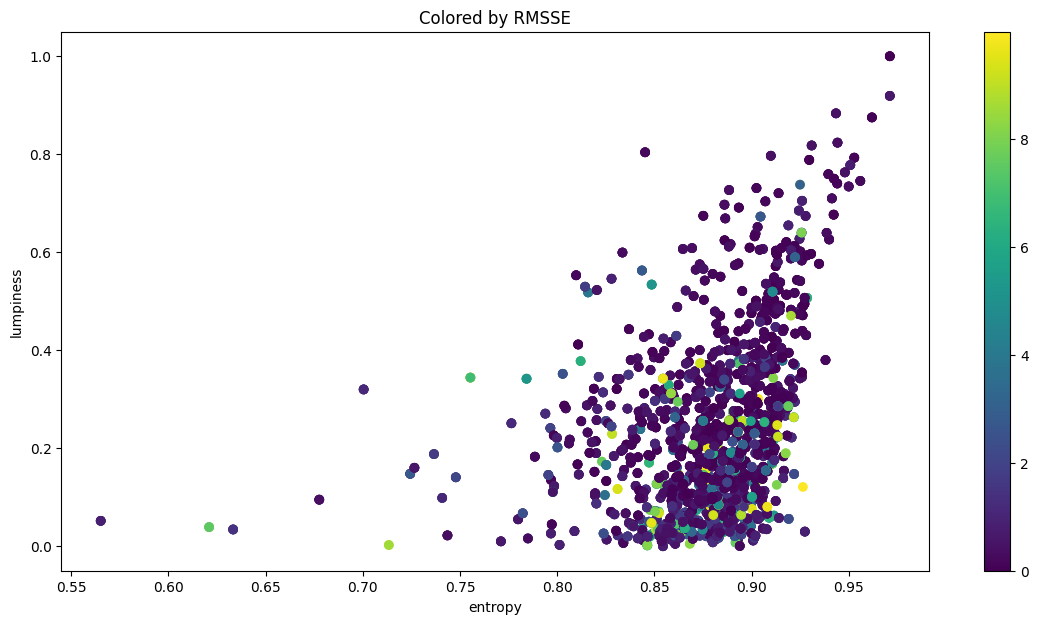

In [32]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['lumpiness'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('lumpiness')
plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

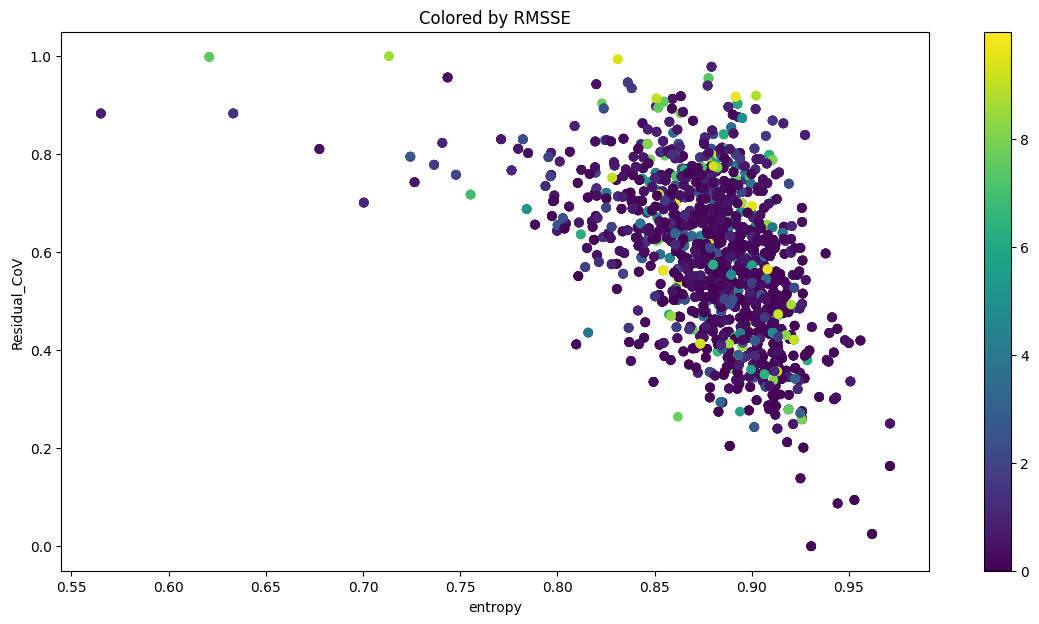

In [33]:
# Scatter plot with rmsse on x and entropy on y color by lumpiness

temp = eval_df_[eval_df_['rmsse']< 10]

plt.figure(figsize=(14,7))
plt.scatter(temp['entropy'], temp['Residual_CoV'], c = temp['rmsse'], cmap = 'viridis')

plt.xlabel('entropy')
plt.ylabel('Residual_CoV')

plt.title('Colored by RMSSE')

# a colorbar
plt.colorbar()

plt.show()

#### LGBM Forecaster

In [34]:
# Define features and transformations 

# Best lag is 11 -> I have already tried
features = {'lags': 13}
transformations = {'normalize': 'StandardScaler'}

# Define model specific
loss_f = 'mae' # Default selection
random_state = 42
model = lgb.LGBMRegressor(objective = loss_f, random_state = random_state, use_missing = True)
model_name = 'lgbm'

In [35]:
lgbm_forecaster = GlobalForecaster(model = model ,
                                    features = features, 
                                    transformations = transformations,
                                    model_name =  model_name)
# Fit 
lgbm_forecaster.fit(sample_df)

# Predict
global_fc = lgbm_forecaster.predict(h = h, cv = cv)

In [36]:
# Define the evaluator
evaluator = Evaluator(sample_df, global_fc, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])
eval_df

,unique_id,Model,fh,cv,rmsse,scaled_error,mape
26616,01008005133A_J.CORTES,Naive,1,1,0.962755,-0.000927,0.00000
26617,01008005133A_J.CORTES,Naive,2,1,1.444132,0.001390,0.60000
26618,01008005133A_J.CORTES,Naive,3,1,0.962755,-0.000927,0.00000
26619,01008005133A_J.CORTES,Naive,4,1,0.962755,-0.000927,0.00000
26620,01008005133A_J.CORTES,Naive,5,1,0.962755,-0.000927,0.00000
...,...,...,...,...,...,...,...
26611,89012050182_OTHER PROJECTS,lgbm,2,4,20.506993,0.022300,0.99778
26612,89012050182_OTHER PROJECTS,lgbm,3,4,0.070985,-0.000077,0.00000
26613,89012050182_OTHER PROJECTS,lgbm,4,4,0.077225,-0.000084,0.00000
26614,89012050182_OTHER PROJECTS,lgbm,5,4,0.005319,-0.000006,0.00000


#### Temporal Hierarchies

In [37]:
factors = get_factors(freq = h) # 6 months total -> so factors of 6
factors

array([1, 2, 3, 6])

In [38]:
# Starting with Naive
model = 'Naive'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_naive = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])


In [39]:
# Next with ETS
model = 'ETS'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_ets = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [40]:
# Next with ETS
model = 'CrostonOptimized'


thief = THieF(bottom_level_freq = freq, factors = factors, holdout = True, cv = cv)

# Fit
thief.fit(sample_df, format = 'pivoted')

# Base forecasts ETS
base_forecasts_croston = thief.predict(model)
res_1 = thief.base_forecast_residuals

# reconcile
method = 'struc' # only supporting struc because of the few number of in-sampel values on top level for reesidusl

rec_fc_1 = thief.reconcile(method = method)

# Rename y_true to True
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Define metrics
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
# Define the evaluator
evaluator = Evaluator(sample_df, temp, freq = freq, format = 'pivoted')

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [41]:
# Base forecast combinations

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [42]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_mean)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

In [43]:
# Reconcile
# Define a reconciler 
temporal_reconciler = TemporalReconciler(bottom_level_freq = freq, factors=factors, holdout = holdout, cv = cv)

# Fit the reconcilcer
temporal_reconciler.fit(base_forecasts_combined_median)

# Reconcile
rec_fc_1 = temporal_reconciler.reconcile('struc', residual_df = res_1)
rec_fc_1 = rec_fc_1.rename(columns = {'y_true': 'True'})

# Evaluate
temp = rec_fc_1[rec_fc_1['temporal_level'] == 1]
evaluator = Evaluator(sample_df, rec_fc_1, freq = freq)

# Evaluate
eval_df_new = evaluator.evaluate(metrics = metrics)

# Concat with eval_df
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Sectional

In [44]:
# Initialize Arguments
current = ['ID', 'Brand']
correct = ['ID', 'Brand']
splitter = '_'
total = True

In [45]:
# Start with Naive
model = 'Naive'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_naive = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [46]:
# Start with Naive
model = 'ETS'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_ets = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [47]:
# Start with Naive
model = 'CrostonOptimized'


# Define CHieF
chief = CHieF(bottom_level_freq = freq, h=h, holdout = holdout, cv = cv)

# Fit CHieF -> builds the hierarchical format
chief.fit(df = sample_df, current_format=current, corrected_format=correct, splitter=splitter, add_total = total, format = 'pivoted')

# Get all base forecasts
base_forecasts_croston = chief.predict(models = [model])
method = 'struc'

# Reconcile
reconciled_forecasts_2 = chief.reconcile(method = method)

# Rename column y_pred to y
reconciled_forecasts_2 = reconciled_forecasts_2.rename(columns = {'y_pred':'y'})

# Add the cross-sectional-level column indicating the hierarchica level
rec_extended = hierarchical_to_transaction(reconciled_forecasts_2, chief.hierarchical_format, sort_by = False, format = 'transaction')
rec_extended = rec_extended[rec_extended['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(chief.cross_sectional_df, rec_extended, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [48]:
# Base forecast combinations

# Extend forecasts to include the hierarchical level
base_forecasts_naive = hierarchical_to_transaction(base_forecasts_naive, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_ets = hierarchical_to_transaction(base_forecasts_ets, chief.hierarchical_format, sort_by = False, format = 'transaction')
base_forecasts_croston = hierarchical_to_transaction(base_forecasts_croston, chief.hierarchical_format, sort_by = False, format = 'transaction')


# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'True':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'True_first': 'True', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'True', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'True', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

base_forecasts_combined_median

,unique_id,cross_sectional_level,fh,cv,y,True,date,Model
0,T,total,1,1,5.683061e+06,7017476.0,2021-05-31,Median_Combination
1,T,total,2,1,5.683061e+06,4198056.0,2021-06-30,Median_Combination
2,T,total,2,2,6.263831e+06,4198056.0,2021-06-30,Median_Combination
3,T,total,3,1,5.683061e+06,2602937.0,2021-07-31,Median_Combination
4,T,total,3,2,7.017476e+06,2602937.0,2021-07-31,Median_Combination
...,...,...,...,...,...,...,...,...
27019,T_PRIVATE LABEL_81808100162,ID,7,3,4.932607e+02,0.0,2021-11-30,Median_Combination
27020,T_PRIVATE LABEL_81808100162,ID,7,4,4.932607e+02,0.0,2021-11-30,Median_Combination
27021,T_PRIVATE LABEL_81808100162,ID,8,3,4.932607e+02,16000.0,2021-12-31,Median_Combination
27022,T_PRIVATE LABEL_81808100162,ID,8,4,4.932607e+02,16000.0,2021-12-31,Median_Combination


In [49]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_median, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [50]:
# Define the reconciler
reconciler = CrossSectionalReconciler(bottom_level_freq=freq, h = h, holdout = holdout, cv = cv)

# fit the reconciler
reconciler.fit(df = base_forecasts_combined_mean, s_mat = chief.S_mat)

# reconcile
reconciled_forecasts = reconciler.reconcile(method = 'struc')

reconciled_forecasts = reconciled_forecasts[reconciled_forecasts['cross_sectional_level'] == 'ID']
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
reconciled_forecasts = reconciled_forecasts.rename(columns = {'y_pred':'y'})

evaluator = Evaluator(chief.cross_sectional_df, reconciled_forecasts, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)

# fix the unique_id
# split unique_id on _ and keep after the first split, then join with _
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Cross-Temporal

In [51]:
# Start with Naive
models = 'Naive'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_naive = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Naive'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [52]:
# Start with Naive
models = 'ETS'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_ets = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-ETS'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [53]:
# Start with Naive
models = 'CrostonOptimized'

# Define the object
ct = C_THieF(bottom_level_freq=freq, factors = factors, h = h, holdout = holdout, cv = cv)

# Fit to build the hierarchical structures
ct.fit(df = sample_df, 
       current_format = current, 
       corrected_format = correct, 
       splitter = splitter, 
       add_total = total,
       format = 'pivoted')


# Generate base forecasts for each cross-sectional and temporal level
base_forecasts_croston = ct.predict(models = models)

# Reconcile
rec = ct.reconcile('struc', 'struc')

# Evaluate

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-CrostonOptimized'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])


In [54]:
# Base forecast combinations
# Change some types
base_forecasts_naive['cross_sectional_level'] = base_forecasts_naive['cross_sectional_level'].astype(str)
base_forecasts_ets['cross_sectional_level'] = base_forecasts_ets['cross_sectional_level'].astype(str)
base_forecasts_croston['cross_sectional_level'] = base_forecasts_croston['cross_sectional_level'].astype(str)

# concat all base forecasts
base_forecasts_combined = pd.concat([base_forecasts_naive, base_forecasts_ets, base_forecasts_croston])

# Take the mean and the median per unique_id, temporal_level, fh,cv 
base_forecasts_combined = base_forecasts_combined.groupby(['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv']).agg({'y': ['mean', 'median'],'y_true':'first', 'date':'first' }).reset_index()

# unstack columns
base_forecasts_combined.columns = base_forecasts_combined.columns.map('_'.join).str.strip('_')
# Drop the "_first" suffix from the last 2 columns
base_forecasts_combined = base_forecasts_combined.rename(columns = {'y_true_first': 'y_true', 'date_first': 'date'})

# take two seperate dfs, one for t he mean one for the median
base_forecasts_combined_mean = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_mean', 'y_true', 'date']]
# Rename y_mean to y
base_forecasts_combined_mean = base_forecasts_combined_mean.rename(columns = {'y_mean': 'y'})
base_forecasts_combined_mean['Model'] = 'Mean_Combination'

base_forecasts_combined_median = base_forecasts_combined[['unique_id', 'temporal_level', 'cross_sectional_level', 'fh', 'cv', 'y_median', 'y_true', 'date']]
# Rename y_median to y
base_forecasts_combined_median = base_forecasts_combined_median.rename(columns = {'y_median': 'y'})
base_forecasts_combined_median['Model'] = 'Median_Combination'

In [55]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_median, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Median_Combination'

# Concat
eval_df = pd.concat([eval_df, eval_df_new])

In [56]:
cross_temporal_reconciler = CrossTemporalReconciler(bottom_level_freq = freq, factors = factors, h = h, holdout = holdout, cv = cv)

# fit
cross_temporal_reconciler.fit(base_forecasts_combined_mean, cross_sectional_Smat = ct.s_mat_cross, residual_df = ct.residuals)

# Reconcile
rec = cross_temporal_reconciler.reconcile('struc', 'struc')

# Rename
rec = rec.rename(columns = {'y_rec_cross_temporal':'y', 'y_true': 'True'})
rec = rec[(rec['cross_sectional_level'] == 'ID') & (rec['temporal_level'] == 1)]
# Define the evaluator
# I need to pass the new hierarchical df as the df argument
evaluator = Evaluator(ct.h_df, rec, freq = freq, format = 'pivoted')

eval_df_new = evaluator.evaluate(metrics = metrics)
eval_df_new['unique_id'] = eval_df_new['unique_id'].str.split('_', n = 1, expand = True)[1]
eval_df_new['Model'] = 'CTR-struc-Mean_Combination'
# Concat
eval_df = pd.concat([eval_df, eval_df_new])

#### Analyze Results

In [57]:
# Drop any duplicates
eval_df = eval_df.drop_duplicates(subset = ['unique_id', 'Model', 'fh', 'cv'])

In [58]:
# Best model
eval_df.groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
14,TR-struc-AutoETS,6.746077,-1.031536e-03,0.280308
18,TR-struc-Naive,6.597819,-6.125376e-04,0.285002
5,CTR-struc-Naive,0.177736,-4.445132e-07,0.285002
0,AutoETS,6.055183,-8.159697e-04,0.291903
6,CrostonOptimized,5.610154,5.055481e-05,0.304104
15,TR-struc-CrostonOptimized,6.022943,7.978014e-04,0.307177
19,lgbm,4.957045,3.248883e-03,0.333529
13,SeasonalNaive,7.777505,-2.075383e-03,0.355019
12,Naive,6.209551,-1.711427e-04,0.358386
11,HR-struc-Naive,0.188941,-1.584490e-07,0.358386


In [59]:
# Best model no outliers
eval_df[eval_df['rmsse'] < 10].groupby(['Model']).mean().reset_index().drop('cv', axis = 1).sort_values('mape')

,Model,rmsse,scaled_error,mape
18,TR-struc-Naive,1.099387,-3.201868e-04,0.259594
14,TR-struc-AutoETS,1.187758,-4.072692e-04,0.269213
15,TR-struc-CrostonOptimized,1.148847,-3.302348e-04,0.271340
0,AutoETS,1.144592,-3.627466e-04,0.283031
6,CrostonOptimized,1.108085,-3.170877e-04,0.283649
5,CTR-struc-Naive,0.147037,-6.261547e-07,0.284694
19,lgbm,0.622837,2.781463e-04,0.287131
13,SeasonalNaive,0.688446,2.016664e-05,0.299952
12,Naive,0.707407,1.652318e-05,0.314567
11,HR-struc-Naive,0.133770,-1.525247e-07,0.357367


In [60]:
import seaborn as sns

In [61]:
def classify_techniques(model):
    if 'CTR' in model:
        out = 'Cross_Temporal'
    elif 'TR' in model:
        out = 'Temporal'
    elif 'HR' in model:
        out = 'Cross_Sectional'
    else:
        out = 'Base'
    return out

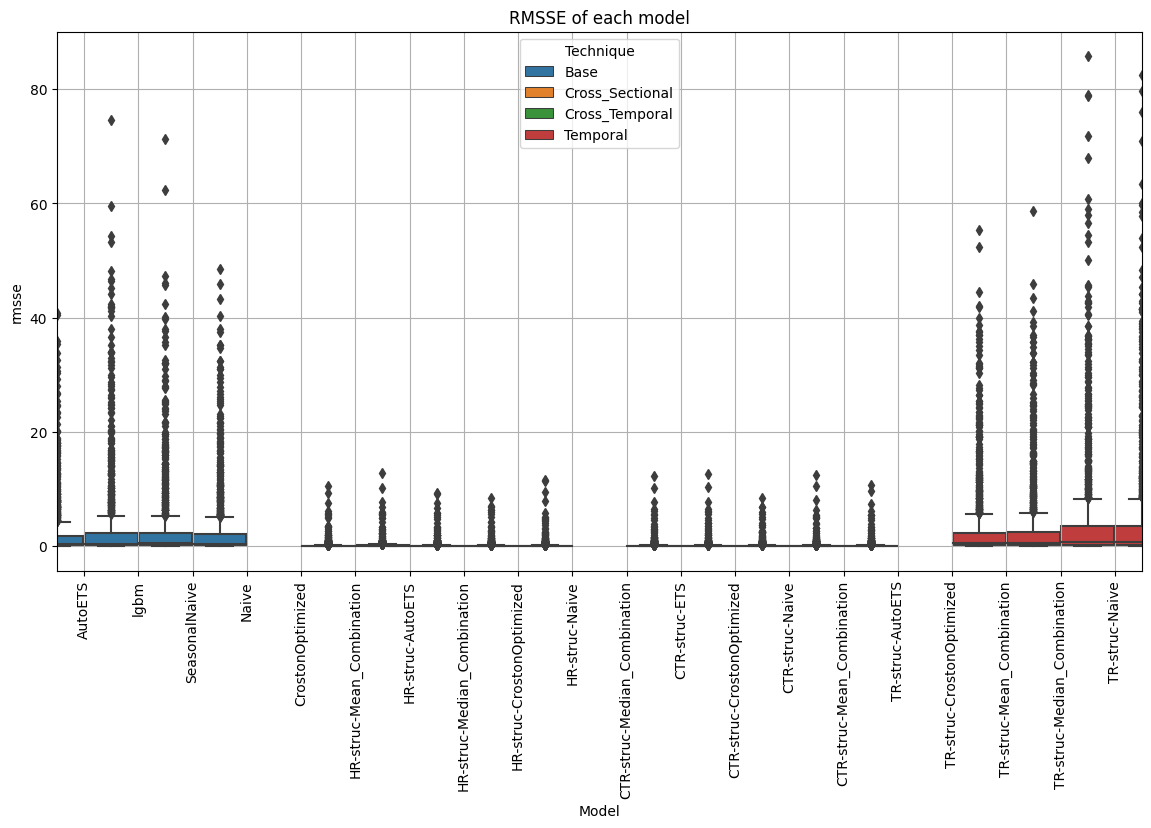

In [62]:
# remove out
remove_out = True
total_outliers = 25

eval_df_group = eval_df.groupby(['unique_id','Model']).mean().reset_index().drop('cv', axis = 1)
# classify techniques
eval_df_group['Technique'] = eval_df_group['Model'].apply(classify_techniques)

# find the outlier series
# mean rmsse over 50
outliers = eval_df_group.groupby(['unique_id']).mean().reset_index().sort_values('rmsse', ascending = False).head(total_outliers)['unique_id'].values

if remove_out:
    eval_df_group = eval_df_group[~eval_df_group['unique_id'].isin(outliers)]

# Remove outlier mapes
#eval_df_group = eval_df_group[eval_df_group['rmsse'] < 10]

# A boxplot for the rmsse of each model on the eval_df_group df
# Models should be grouped based on the Technique

# Sort the dataframe based on the technique
eval_df_group = eval_df_group.sort_values('Technique')

# Figure
fig, ax = plt.subplots(figsize = (14, 7))

# Boxplots, color should be based on the technique
# Distance and width should be adjusted
sns.boxplot(x = 'Model', y = 'rmsse', data = eval_df_group, ax = ax, hue = 'Technique', width = 4)

ax.grid()

ax.set_title('RMSSE of each model')

ax.set_xlabel('Model')

ax.set_ylabel('rmsse')

plt.xticks(rotation = 90)

plt.show()

